# DataLoader
- 학습을 하기 위해서는 데이터를 불러와야 한다.
- 이전에는 데이터를 하나하나 가져오는 방식으로 불러옴
- Pytorch에 내장된 함수를 이용해서 편리하게 불러오는 방법을 알아보자

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### ImageFolder
- Torchvision 라이브러리에 있는 함수
- 데이터들이 각각의 레이블파일로 구축되어있을 때 사용하는 함수
> **ImageFolder는 데이터를 3채널로만 출력을 하기 때문에 1채널만 있는 이미지에 대해서는 따로 수정을 해줘야한다.**

In [2]:
# 데이터 경로 확인
print(os.listdir('data/mnist_png/'))
print(os.listdir('data/mnist_png/training'))
print(os.listdir('data/mnist_png/training/1')[:5])

['testing', 'training']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['10006.png', '10007.png', '1002.png', '10020.png', '10027.png']


In [3]:
# Datasets 만들기
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_path = 'data/mnist_png/training'
trainset = torchvision.datasets.ImageFolder(root = train_path,
                                           transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True)

images, labels = iter(trainloader).next()
images.size() # batch_size X Channel X Image_size

torch.Size([4, 3, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([7, 8, 4, 7])


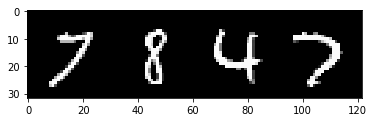

In [4]:
image_grid = torchvision.utils.make_grid(images).permute(1,2,0)
image_np = np.array(image_grid)
plt.imshow(image_np)
print(labels)

### Custom Datasets
- 기존에는 datasets을 바로 다운받아서 사용했다.(MNIST나 CIFAR10의 경우)
- torch에 있는 Dataset를 직접 만들어서 DataLoader로 불러오기
- Dataset 함수의 형태를 이해하고 customize 해보기

### 1. 기존 방법
- 필요한 데이터셋을 다운로드한 후 불러오기
- 불러 온 데이터셋을 바로 Dataloader에 입력

In [5]:
import torchvision

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=1)

### 2. Custom한 방법
Dataset을 불러오는 class를 직접 코딩
1. 데이터의 위치 파악
2. 데이터와 해당 데이터의 레이블 확인

In [6]:
from PIL import Image
from torch.utils.data import Dataset
import os
from glob import glob

In [7]:
# 데이터 위치 파악
data_path = os.listdir('data/cifar10_png')
print(data_path)

['labels.txt', 'test', 'train']


In [8]:
train_path = glob('data/cifar10_png/train/*.png')
test_path = glob('data/cifar10_png/test/*.png')
print(len(train_path), len(test_path))

50000 10000


In [9]:
# 레이블 추출
example = train_path[0]
print(example, '\n')

example = os.path.basename(example)
print(example, '\n')

example = example.split('_')[-1]
print(example, '\n')

example = example.replace('.png', '')
print(example)

data/cifar10_png/train\0_frog.png 

0_frog.png 

frog.png 

frog


In [10]:
# 레이블 종류
def get_label_name(path):
    return os.path.basename(path).split('_')[-1].replace('.png','')

classes = np.unique([get_label_name(path) for path in train_path])
print(classes)

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [11]:
# 레이블 추출 함수(위 과정 결함)
def get_label(path):
    label_name = os.path.basename(path).split('_')[-1].replace('.png', '')
    label = np.argmax(classes == label_name)
    
    return int(label)

get_label(train_path[0])

6

frog


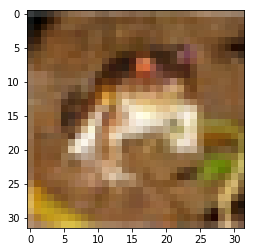

In [12]:
# Image 불러오기
img = Image.open(train_path[0])
img = np.array(img)
plt.imshow(img, 'gray')
print(classes[get_label(train_path[0])])

In [13]:
# 위 모든 것을 결함
class myDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.data_path)
        
    def __getitem__(self, idx):
        path = self.data_path[idx]
        
        # Image 불러오기
        image = Image.open(path)
        
        # Label 불러오기
        label = get_label(path)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label
    
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1])
])

trainset = myDataset(train_path, transform=transform)
testset = myDataset(test_path, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

iter(trainloader).next()

[tensor([[[[0.1020, 0.1020, 0.0980,  ..., 0.0863, 0.0902, 0.0902],
           [0.0980, 0.0980, 0.1020,  ..., 0.0824, 0.0863, 0.0863],
           [0.1020, 0.0980, 0.0941,  ..., 0.0824, 0.0863, 0.0902],
           ...,
           [0.1294, 0.1216, 0.1255,  ..., 0.0902, 0.0941, 0.1059],
           [0.1098, 0.1059, 0.1098,  ..., 0.0863, 0.0980, 0.1020],
           [0.1137, 0.1059, 0.1098,  ..., 0.0941, 0.0980, 0.0980]],
 
          [[0.0667, 0.0667, 0.0627,  ..., 0.0510, 0.0549, 0.0549],
           [0.0627, 0.0627, 0.0667,  ..., 0.0471, 0.0510, 0.0510],
           [0.0667, 0.0627, 0.0588,  ..., 0.0471, 0.0510, 0.0549],
           ...,
           [0.0980, 0.0941, 0.0941,  ..., 0.0627, 0.0667, 0.0745],
           [0.0784, 0.0745, 0.0784,  ..., 0.0588, 0.0706, 0.0706],
           [0.0824, 0.0784, 0.0784,  ..., 0.0706, 0.0706, 0.0667]],
 
          [[0.1412, 0.1412, 0.1373,  ..., 0.1176, 0.1216, 0.1294],
           [0.1373, 0.1373, 0.1412,  ..., 0.1137, 0.1176, 0.1255],
           [0.1412, 0.13